# ex5 - Bias v.s.Variance
在本次练习中，实现正则化线性回归，并使用它来研究具有不同偏差-方差特性的模型

### Regularized Linear Regression
在练习的前半部分，你将实现正则化线性回归，通过水库的水位变化来预测从水坝流出的水量。

**Visualizing the dataset**
$X$：水位变化的历史记录
$y$：从水坝流出的水量
这个数据集被分为三个部分：  
- training set : 用于模型学习，$X, y$
- cross validation set : 用于决定正则化参数，$Xval, yval$
- test set : 用于评估性能，模型训练中是不可见的，$Xtest, ytest$

In [1]:
import numpy as np
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

In [2]:
data = loadmat('ex5data1.mat')
X = np.insert(data['X'], 0, 1, 1)
y = data['y']
Xval = np.insert(data['Xval'], 0, 1, 1)
yval = data['yval']
Xtest = np.insert(data['Xtest'], 0, 1, 1)
ytest = data['ytest']

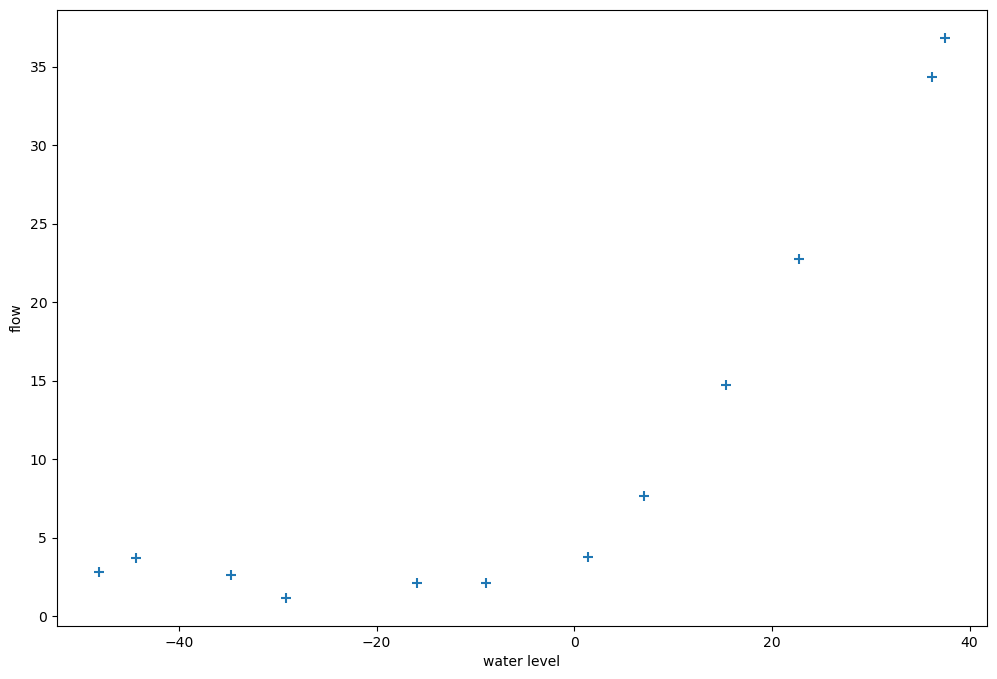

In [3]:
df = pd.DataFrame({'water level': data['X'].ravel(), 'flow' : y.ravel()})
df.plot.scatter(x = 'water level', y =  'flow', figsize = (12, 8),s = 50, marker = '+')
plt.show()

**regularized cost function:**
<img src = "cost.jpg" width = 400>

In [4]:
def costReg(theta, X, y, Lambda):
    theta = np.matrix(theta)
#     print(X.shape, theta.shape)
    inner = np.power(X @ theta.T - y, 2)
    cost = np.sum(inner) /(2 * len(X))
    reg = (Lambda / (2 * len(X))) * np.sum(np.power(theta[:, 1:], 2))
    return cost + reg

In [5]:
theta = np.ones(X.shape[1])
Lambda = 1
costReg(theta, X, y, Lambda)

303.9931922202643

**regularized gradient:**
<img src = "grad.jpg" width = 400>

In [6]:
def gradientReg(theta, X, y, Lambda):    
    theta = np.matrix(theta)
    h = X @ theta.T
    error = h - y
    
    reg = (Lambda / len(X)) * theta.T
    reg[0] = 0
    grad = X.T @ error / len(X) + reg
    
    return np.array(grad).flatten()

In [7]:
gradientReg(theta, X, y, Lambda)

array([-15.30301567, 598.25074417])

In [8]:
def trainLinearReg(theta, X, y, Lambda):
    res = opt.minimize(fun=costReg, x0=theta,
                   args=(X, y, Lambda), method='TNC',
                   jac=gradientReg,
                   options={'disp': True})
    return res

res = trainLinearReg(theta, X, y, Lambda)
theta_final = res['x']
theta_final

array([13.08771417,  0.367742  ])

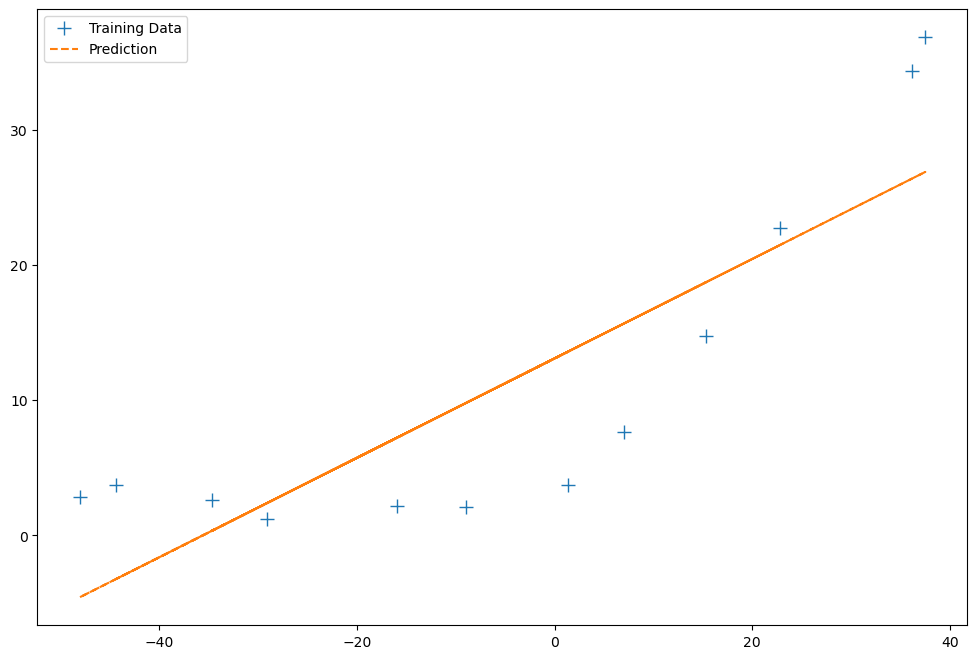

In [9]:
def plotFit(theta, X, y):
    h = X @ theta.T
    x = X[:, 1:]

    fig, ax = plt.subplots(figsize = (12, 8))
    ax.plot(x, y, '+', label = 'Training Data', markersize = 10)# 所给数据的散点图
    ax.plot(x, h, '--', label = 'Prediction') # 最终确认的拟合直线
    ax.legend()#图例，就是左上角那个说明块
    plt.show()

plotFit(theta_final, X, y)

### Learning curves
学习曲线将训练和交叉验证误差绘制为训练集的函数

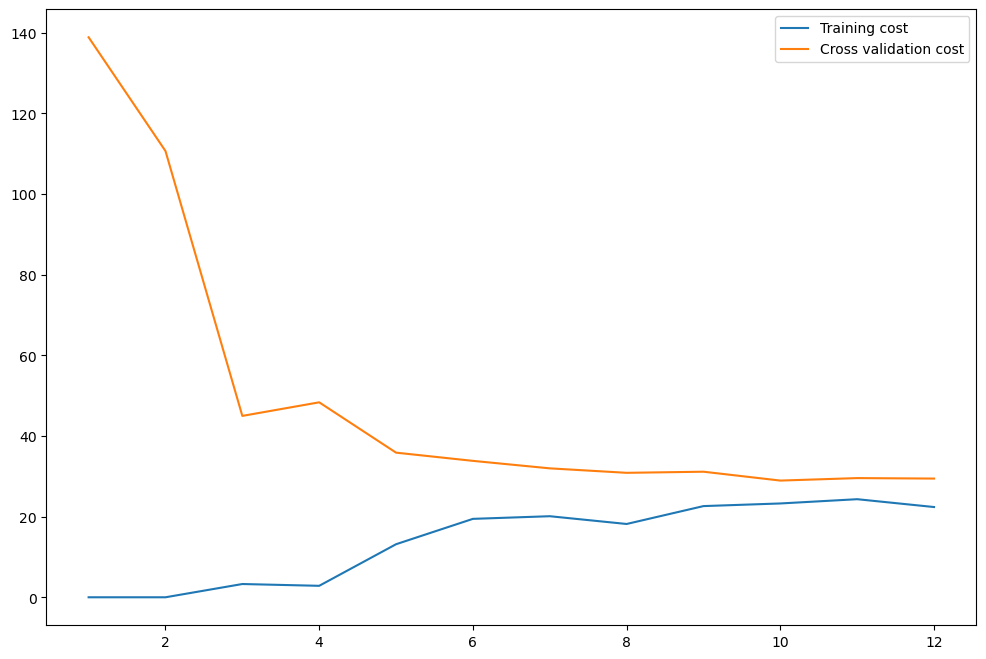

In [10]:
def plotLearningRate(X, y, Xval, yval, Lambda):
    m = X.shape[0]
    error_train = np.zeros(m)
    error_val = np.zeros(m)

    for i in range(m):
        theta = np.ones(X.shape[1])
        res = trainLinearReg(theta, X[:i + 1, :], y[:i + 1, :], Lambda)
        error_train[i] = costReg(res['x'], X[:i + 1, :], y[:i + 1, :], 0)
        error_val[i] = costReg(res['x'], Xval, yval, 0)

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(np.arange(1, m + 1), error_train, label='Training cost')
    ax.plot(np.arange(1, m + 1), error_val, label='Cross validation cost')
    ax.legend(loc='best')
    plt.show()
    
plotLearningRate(X, y, Xval, yval, Lambda)

### Polynomial regression
由上图可知，这个模型欠拟合了，因此我们需要添加更多的特征来解决这个问题。  
使用多项式回归的假设函数如下：
<img src = "poly.jpg" width = 520>

In [11]:
def polyFeatures(X, power, as_ndarray = False):
    X = X.ravel()
    data = {'f{}'.format(i) : np.power(X, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)
    return df.values if as_ndarray else df

In [12]:
polyFeatures(data['X'], power = 3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


使用线性回归的代价函数来训练多项式回归。

In [13]:
def featureNormalize_(df):
    return df.apply(lambda col: (col - col.mean()) / col.std())

In [14]:
def preparPolyData(*args, power):
    def prepare(x):
        df = polyFeatures(x, power)
        ndarr = featureNormalize_(df).values
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    
    return [prepare(x) for x in args]

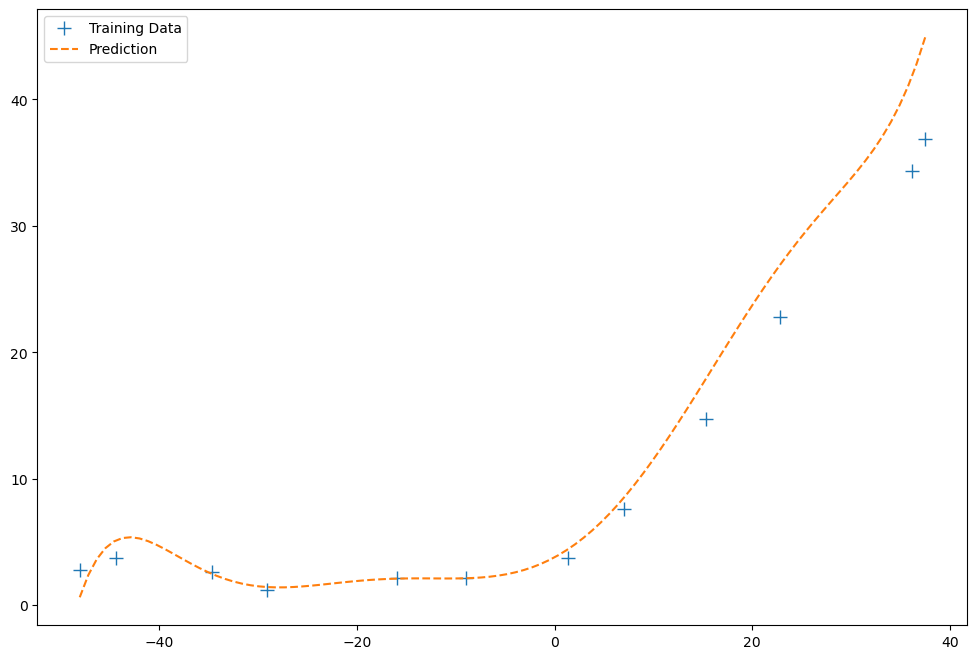

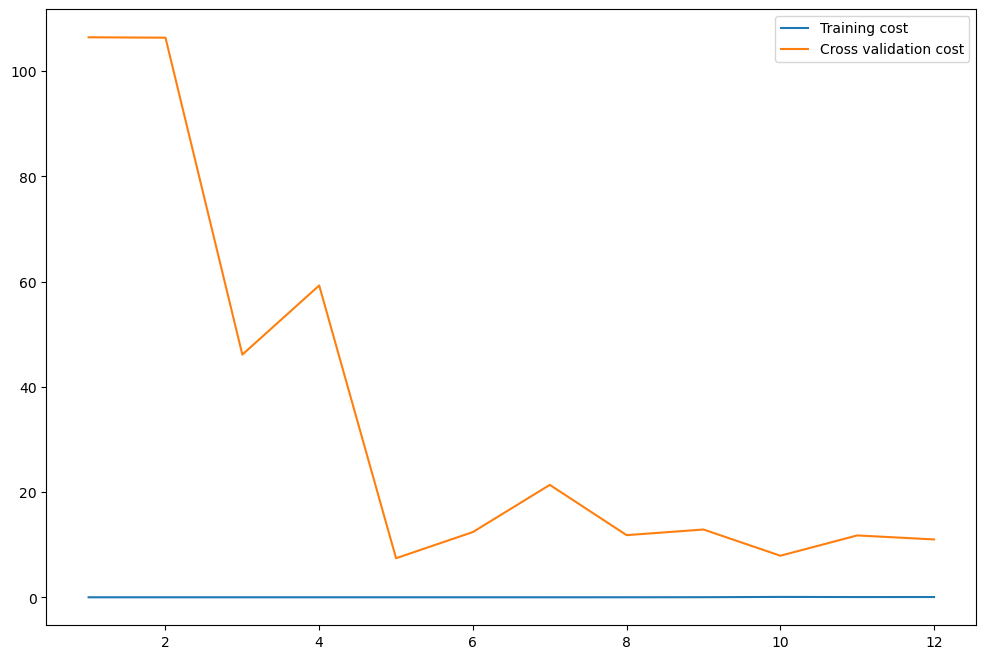

In [15]:
def polyRegression(Lambda):
    X_poly, Xval_poly, Xtest_poly = preparPolyData(data['X'], data['Xval'], data['Xtest'], power = 8)
    theta1 = np.ones(X_poly.shape[1])
    res = trainLinearReg(theta1, X_poly, y, Lambda)

    # 多项式拟合图
    fig, ax = plt.subplots(figsize = (12, 8))
    x = X[:, 1:]
    ax.plot(x, y, '+', label = 'Training Data', markersize = 10)# 所给数据的散点图

    X_fit = np.linspace(x.min(), x.max(), 100)
    X_fit_poly = preparPolyData(X_fit, power = 8)[0]
    h = X_fit_poly @ res['x'].T
    ax.plot(X_fit, h, '--', label = 'Prediction') # 最终确认的拟合直线
    ax.legend()#图例，就是左上角那个说明块
    plt.show()

    # 多项式学习曲线
    plotLearningRate(X_poly, y, Xval_poly, yval, Lambda)
    
polyRegression(0)

### Adjusting the regularization parameter 
从上图可知，当$\lambda = 0$时，Training cost太低，是过拟合了。  
因此，在这个部分，我们将观察$\lambda$是如何影响正则化多项式回归的bias-variance的。

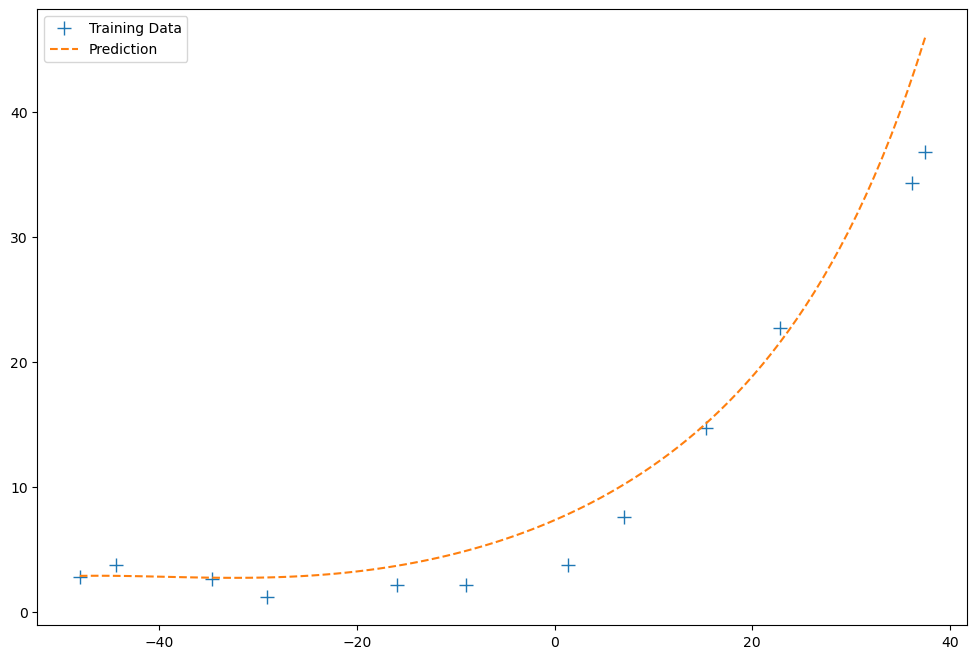

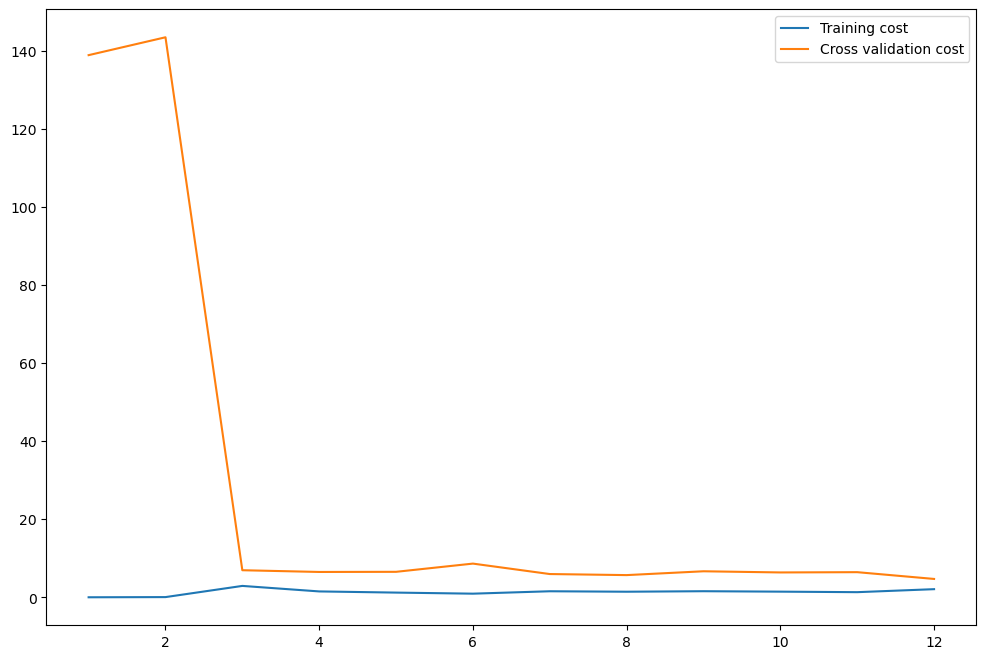

In [16]:
polyRegression(1) # Lambda = 1

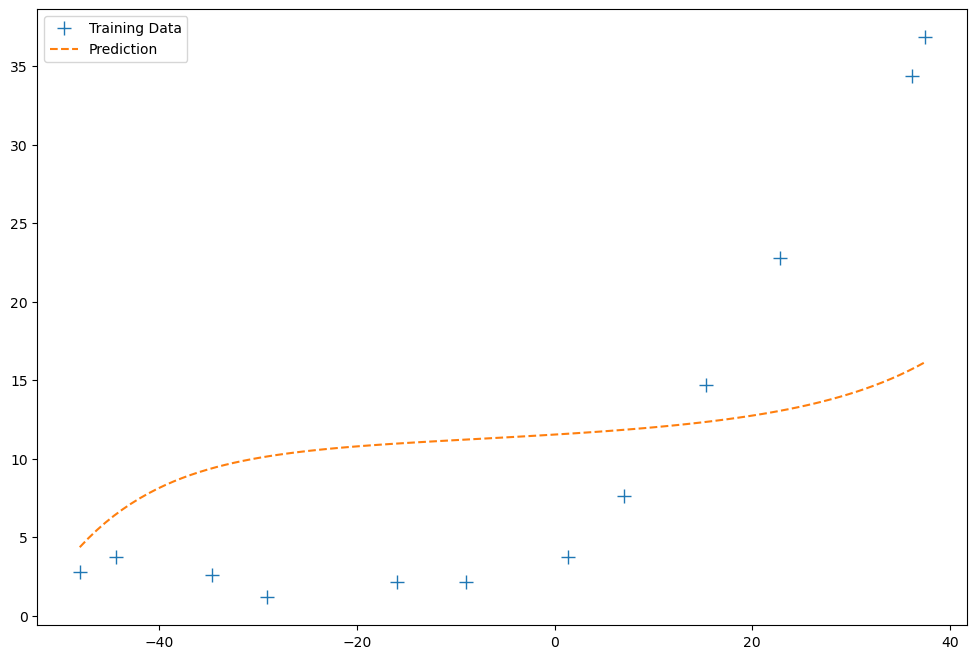

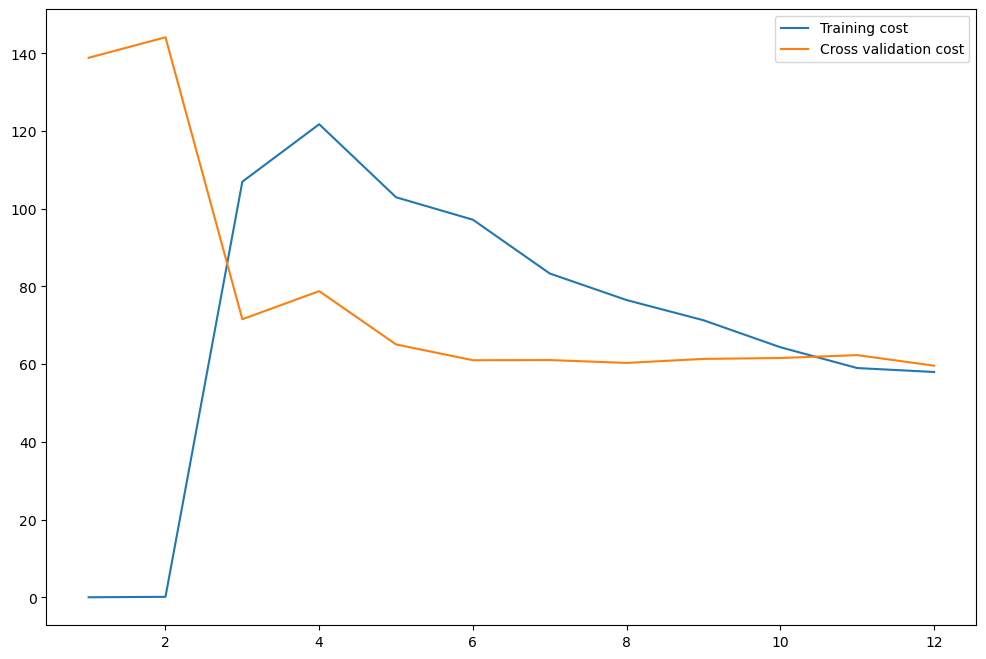

In [17]:
polyRegression(100) # Lambda = 100

### Selecting $\lambda$ using a cross validation set
在这个部分，实现一个选择$\lambda$的自动化方法

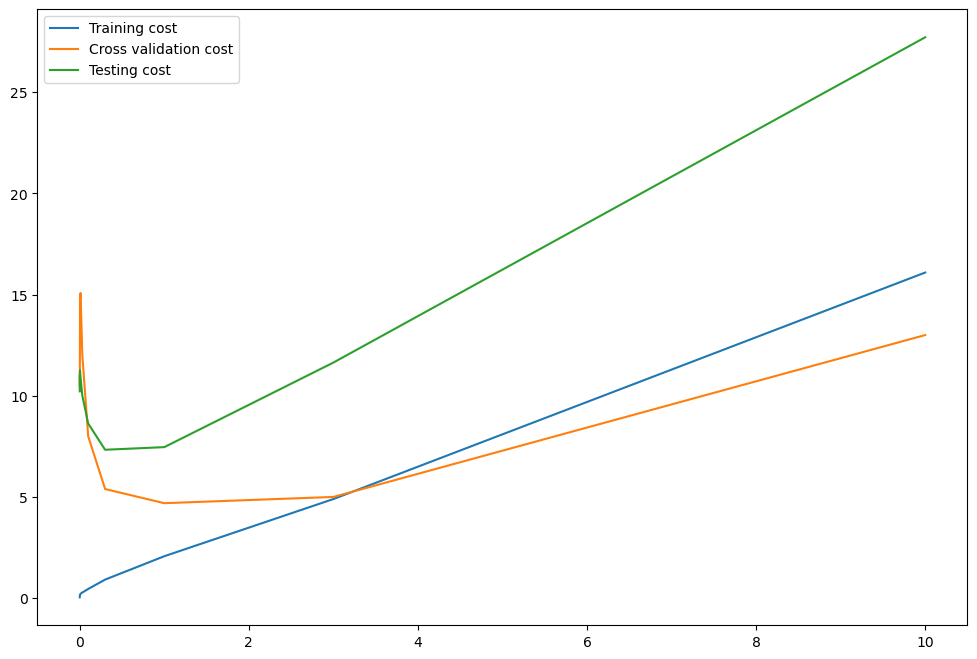

In [18]:
candidateLambda = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

# 使用多项式回归的特征
def validationCurve(X, y, Xval, yval, Xtest, ytest, candidateLambda):
    n = len(candidateLambda)
    error_train = np.zeros(n)
    error_val = np.zeros(n)    
    error_test = np.zeros(n)    
  
    for i in range(n):
        theta = np.ones(X.shape[1])
        res = trainLinearReg(theta, X, y, candidateLambda[i])
        error_train[i] = costReg(res['x'], X, y, 0)
        error_val[i] = costReg(res['x'], Xval, yval, 0)
        error_test[i] = costReg(res['x'], Xtest, ytest, 0)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(candidateLambda, error_train, label='Training cost')
    ax.plot(candidateLambda, error_val, label='Cross validation cost')
    ax.plot(candidateLambda, error_test, label='Testing cost')
    ax.legend(loc='best')
    plt.show()
    return error_train, error_val, error_test

X_poly, Xval_poly, Xtest_poly = preparPolyData(data['X'], data['Xval'], data['Xtest'], power = 8)
error_train, error_val, error_test = validationCurve(X_poly, y, Xval_poly, yval, Xtest_poly, ytest, candidateLambda)

In [19]:
for i in range(len(candidateLambda)):
    print('when Lambda = {}, test error={}.'.format(candidateLambda[i],error_test[i]))

when Lambda = 0, test error=10.223149861283044.
when Lambda = 0.001, test error=11.052857080857732.
when Lambda = 0.003, test error=11.263677315313222.
when Lambda = 0.01, test error=10.8809886616356.
when Lambda = 0.03, test error=10.02222446353958.
when Lambda = 0.1, test error=8.632021830895702.
when Lambda = 0.3, test error=7.3365462792670275.
when Lambda = 1, test error=7.466290243163922.
when Lambda = 3, test error=11.643938576552777.
when Lambda = 10, test error=27.71508030083509.
